In [1]:
import torch
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1]]
sns.set_palette('tab10')

root_path = "/home/yigit/projects/mbcnp/outputs/sine/"
test_names = ["1_sine", "2_sines", "3_sines", "4_sines"]
# test_names = ["1_sine", "2_sines", "3_sines", "4_sines", "8_sines"]

# root_path = "/home/yigit/projects/mbcnp/outputs/combined/large/"
# test_name = "diff_obs"

out_path = f'{root_path}comparison_all/'
if not os.path.exists(out_path):
    os.makedirs(out_path)

errors_and_losses = {}
all_num_tests = {}
test_id = 0

for test_path in [f'{root_path}{test_name}/' for test_name in test_names]:
    cnp_tls, cnp_ves, wta_tls, wta_ves = {}, {}, {}, {}
    num_tests = 0

    for suffix in os.listdir(test_path):
        if suffix.startswith('169'):
            d = os.path.join(test_path, suffix)
            if os.path.isdir(d):
                tl_code, ve_code = 'training_loss', 'validation_error'
                cnp_tl_path, cnp_ve_path = f'{d}/cnp_{tl_code}.pt', f'{d}/cnp_{ve_code}.pt'
                wta_tl_path, wta_ve_path = f'{d}/wta_{tl_code}.pt', f'{d}/wta_{ve_code}.pt'

                cnp_tl, cnp_ve = torch.load(cnp_tl_path, map_location=torch.device('cpu')), torch.load(cnp_ve_path, map_location=torch.device('cpu'))
                wta_tl, wta_ve = torch.load(wta_tl_path, map_location=torch.device('cpu')), torch.load(wta_ve_path, map_location=torch.device('cpu'))

                tl_size, ve_size = min(cnp_tl.shape[0], wta_tl.shape[0]), min(cnp_ve.shape[0], wta_ve.shape[0])
                # if tl_size < 500_000:
                #     continue

                cnp_tl, cnp_ve = cnp_tl[:tl_size], cnp_ve[:ve_size]
                wta_tl, wta_ve = wta_tl[:tl_size], wta_ve[:ve_size]

                cnp_tls.update({suffix:cnp_tl})
                cnp_ves.update({suffix:cnp_ve})
                wta_tls.update({suffix:wta_tl})
                wta_ves.update({suffix:wta_ve})
                num_tests += 1
    print(num_tests)
    errors_and_losses.update({test_names[test_id]: [cnp_tls, cnp_ves, wta_tls, wta_ves]})
    all_num_tests.update({test_names[test_id]:num_tests})
    test_id += 1
        

20
20
20
29


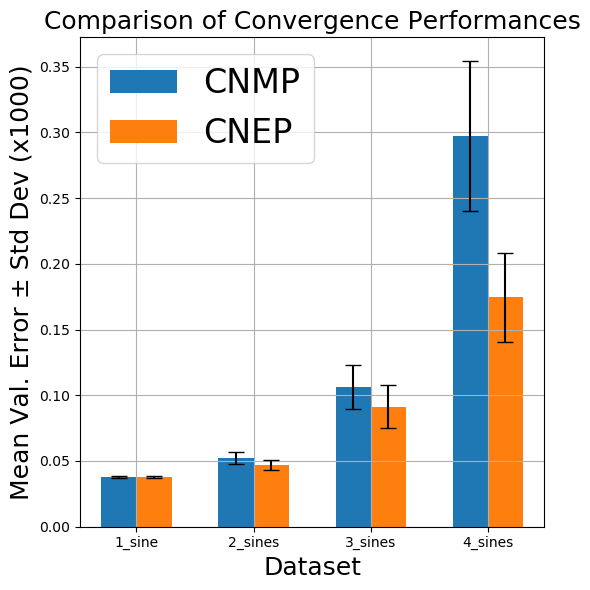

In [8]:
import numpy as np

models = ['CNMP', 'CNEP']
ves = {}
ve_cnp, ve_wta, dev_cnp, dev_wta, err_cnp, err_wta = [], [], [], [], [], []

for err_key in errors_and_losses.keys():
    num_tests = all_num_tests[err_key]
    wta_ve_min, cnp_ve_min = np.zeros(num_tests), np.zeros(num_tests)

    cnp_ves, wta_ves = errors_and_losses[err_key][1], errors_and_losses[err_key][3]

    for i, key in enumerate(cnp_ves.keys()):
        cnp_ve_min[i] = cnp_ves[key].min()
        wta_ve_min[i] = wta_ves[key].min()

    # cnp_ve_min, wta_ve_min = np.array(cnp_ve_min), np.array(wta_ve_min)

    mean_errors = [np.mean(cnp_ve_min), np.mean(wta_ve_min)]
    std_dev = [np.std(cnp_ve_min), np.std(wta_ve_min)]  # Standard dev
    std_err = [np.std(cnp_ve_min)/np.sqrt(num_tests), np.std(wta_ve_min)/np.sqrt(num_tests)]  # Standard error

    ve_cnp.append(mean_errors[0]*1000)
    ve_wta.append(mean_errors[1]*1000)
    dev_cnp.append(std_dev[0]*1000)
    dev_wta.append(std_dev[1]*1000)
    err_cnp.append(std_err[0]*1000)
    err_wta.append(std_err[1]*1000)

    ves.update({err_key: [mean_errors, std_dev, std_err]})


barWidth = 0.3
br1 = np.arange(len(test_names))
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(6, 6))

# for k in ves.keys():
plt.bar(br1, ve_cnp, yerr=dev_cnp, color=colors[0], width=barWidth, capsize=6)
plt.bar(br2, ve_wta, yerr=dev_wta, color=colors[1], width=barWidth, capsize=6)
 
# Adding Xticks
plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Mean Val. Error ± Std Dev (x1000)', fontsize=18)
plt.title('Comparison of Convergence Performances', fontsize=18)

plt.xticks([r + 0.15 for r in range(len(test_names))], test_names)

plt.legend(labels=models, loc='best', fontsize=24)
# plt.show()


# plt.bar(models, mean_errors, yerr=std_dev, capsize=10, color=colors)
# plt.xlabel('Model')
# plt.ylabel('Mean of Minimum Validation Error ± Std Deviation')
# plt.title('Validation Error over Different Runs')
plt.grid(True)
plt.tight_layout()

plt.savefig(f'{out_path}sines_mean_min_ve.png')
plt.show()
# plt.close()



In [9]:
def mean_filter(x: torch.Tensor, window_size):
    return torch.nn.functional.avg_pool1d(x.unsqueeze(0), window_size, stride=1).squeeze(0)

In [10]:
all_cnp_means, all_wta_means = [], []
all_cnp_stds, all_wta_stds = [], []

for err_key in errors_and_losses.keys():  #1_sine, 2_sines ...
    num_tests = all_num_tests[err_key]

    ve_size = next(iter(errors_and_losses[err_key][1].values())).shape[0]
    cnp_means, wta_means = torch.zeros(ve_size), torch.zeros(ve_size)
    cnp_errs, wta_errs = torch.zeros(len(errors_and_losses[err_key][1].keys()), ve_size), torch.zeros(len(errors_and_losses[err_key][1].keys()), ve_size)

    for i, ves_key in enumerate(errors_and_losses[err_key][1].keys()):
        cnp_errors_of_run = errors_and_losses[err_key][1][ves_key]
        wta_errors_of_run = errors_and_losses[err_key][3][ves_key]

        cnp_errs[i], wta_errs[i] = cnp_errors_of_run, wta_errors_of_run

        cnp_means += cnp_errors_of_run
        wta_means += wta_errors_of_run
    
    cnp_means /= num_tests
    wta_means /= num_tests

    s_err_cnp = torch.std(cnp_errs, dim=0) / torch.sqrt(torch.tensor(num_tests))  # Standard error
    s_err_wta = torch.std(wta_errs, dim=0) / torch.sqrt(torch.tensor(num_tests))  # Standard error

    all_cnp_means.append(cnp_means)
    all_wta_means.append(wta_means)
    all_cnp_stds.append(s_err_cnp)
    all_wta_stds.append(s_err_wta)

print(len(all_cnp_means))

4


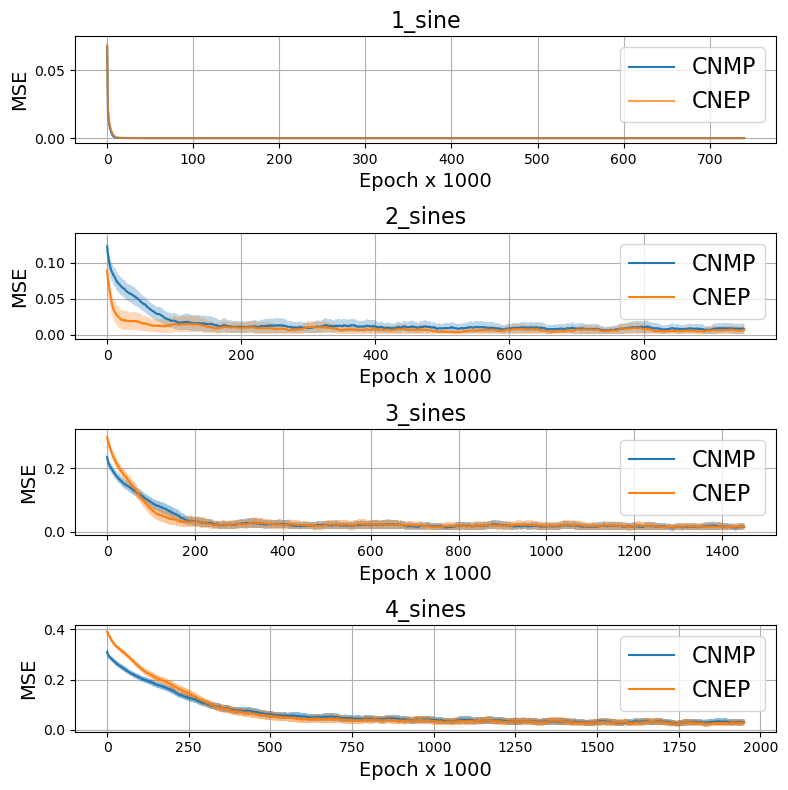

In [13]:
fig, axs = plt.subplots(len(test_names), 1, figsize=(8, 8))
window_sizes = [10, 50, 50, 50]
step = 1

ylabel = 'MSE'
suffix = 've'

for i in range(len(test_names)):    
    t0_filtered, t1_filtered = mean_filter(all_cnp_means[i], window_sizes[i]), mean_filter(all_wta_means[i], window_sizes[i])
    s0_filtered, s1_filtered = mean_filter(all_cnp_stds[i], window_sizes[i]), mean_filter(all_wta_stds[i], window_sizes[i])

    tl_size = t0_filtered.shape[0]
    idx = torch.arange(start=0, end=tl_size, step=step)

    x = torch.arange(idx.shape[0])
    y1, y2 = t0_filtered[idx], t1_filtered[idx]
    e1, e2 = s0_filtered[idx], s1_filtered[idx]

    xlabel = f'Epoch x {step*1000}'

    axs[i].set_title(test_names[i], fontsize=14)
    a0, a1 = 0.99, 0.99
    if i==0:
        a0, a1 = 0.99, 0.75
    axs[i].plot(x, y1, '-', label='CNMP', alpha=a0)
    axs[i].plot(x, y2, '-', label='CNEP', alpha=a1)
    axs[i].errorbar(x, y1, yerr=e1, color=colors[0], alpha=0.1)
    axs[i].errorbar(x, y2, yerr=e2, color=colors[1], alpha=0.1)
    axs[i].set_xlabel(xlabel, fontsize=14)
    axs[i].set_ylabel(ylabel, fontsize=14)
    axs[i].grid(True)
    axs[i].legend(fontsize=14)

plt.tight_layout()

plt.savefig(f'{out_path}mve.png')

plt.show()
